In [1]:
!apt-get install -y xvfb
!pip install Xvfbwrapper
!pip install pyvirtualdisplay
!pip install open3d

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 7,815 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

Support for third party widgets will remain active for the duration of the session. To disable support:

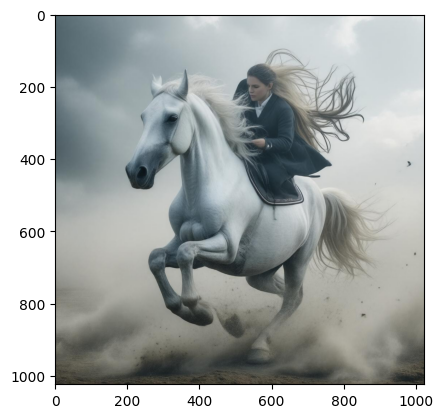

In [13]:
from huggingface_hub import InferenceClient
import matplotlib.pyplot as plt

# Initialize the Inference Client with your Hugging Face token
client = InferenceClient("stabilityai/stable-diffusion-3.5-large-turbo", token="hf_yourtoken")

promot='flyhorse'
# Generate the image based on the text prompt
image = client.text_to_image(f'{promot}')

# Display the generated image
plt.imshow(image)
plt.savefig('texttoimage.png')



In [14]:
import requests
import base64

API_URL = "https://api-inference.huggingface.co/models/openai/clip-vit-large-patch14"
headers = {"Authorization": "Bearer hf_yourtoken"}

def query(data):
	with open(data["image_path"], "rb") as f:
		img = f.read()
	payload={
		"parameters": data["parameters"],
		"inputs": base64.b64encode(img).decode("utf-8")
	}
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()

output = query({
    "image_path": "texttoimage.png",
    "parameters": {"candidate_labels": f'{promot}'},
})
print(output)

[{'score': 1.0, 'label': 'flyhorse'}]


In [17]:
import torch
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
from PIL import Image
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt




feature_extractor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")


new_height = 480 if image.height > 480 else image.height
new_height -= new_height % 32
new_width = int(new_height * image.width / image.height)
diff = new_width % 32
new_width = new_width - diff if diff < 16 else new_width + 32 - diff
new_size = (new_width, new_height)
image = image.resize(new_size)


inputs = feature_extractor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth


pad = 16
output = predicted_depth.squeeze().cpu().numpy() * 1000
output = output[pad:-pad, pad:-pad]
image = image.crop((pad, pad, image.width - pad, image.height - pad))


fix, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax[1].imshow(output, cmap='plasma')
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.savefig('depth_map.png')
plt.show()


In [18]:
import open3d as o3d

depth_image = (output * 255 / np.max(output)).astype('uint8')
image = np.array(image)
depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity=False)


image_np = np.asarray(image_o3d)


height, width = image_np.shape[:2]


camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 500, 500, width / 2, height / 2)



pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
o3d.visualization.draw_geometries([pcd_raw])




cl, ind = pcd_raw.remove_statistical_outlier(nb_neighbors=20, std_ratio=6.0)
pcd = pcd_raw.select_by_index(ind)
pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()


o3d.visualization.draw_geometries([pcd])


mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10, n_threads=1, width=0, scale=1.1, linear_fit=False)[0]
rotation = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
mesh.rotate(rotation, center=(0, 0, 0))


o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)


mesh_uniform = mesh.paint_uniform_color([0.9, 0.8, 0.9])
mesh_uniform.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_uniform], mesh_show_back_face=True)
o3d.io.write_triangle_mesh("mesh.obj", mesh)



o3d.io.write_point_cloud("point_cloud.ply", pcd_raw)



[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
[Open3D WARNING] Write OBJ can not include triangle normals.


True